# Loading Imagenette using SwiftData

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))' SwiftCV
%install '.package(url: "https://github.com/sgugger/SwiftData.git", .branch("master"))' SwiftData
//%install '.package(path: "~/git/SwiftData")' SwiftData

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))
		SwiftCV
	.package(path: "~/git/SwiftData")
		SwiftData
With SwiftPM flags: []
Working in: /tmp/tmpp9x9hx3m/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swiftc: /home/sgugger/anaconda3/lib/libuuid.

In [2]:
import Path
import TensorFlow
import SwiftData
import Foundation

In [3]:
//For image show
import Python
let plt = Python.import("matplotlib.pyplot")

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


This notebook assumes you have [Imagenette](https://github.com/fastai/imagenette) downloaded in the path defined below. Here is the link to [compressed dataset](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz).

In [5]:
let dataPath = Path.home/".fastai"/"data"

## Create a `Batcher`

To create a `Batcher` (which will gather the data lazily using multiprocessing and collate it in batches ready to feed to a model) we need an array of raw items that can fit in memory (in this case, the array of filenames of all images) and a template. The template contains all the details on how to process raw items and collate them in batches, in our case, since we have an image classification problem, there is an `ImageClassificationTemplate` we can use. It only requires two functions: how to open an image and how to label it. 

First, let's get all our image filenames. SwiftData provides a function to easily collect all the files in a directory:

In [6]:
let path = dataPath/"imagenette2"/"train"
let fnames = collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])

### Labels

Before we begin, we need to know how to label our data. Here the labels are given by the names of the parent folder. We gather all possibilities before creating a map from label to index.

In [7]:
let allLabels = fnames.map { $0.parent.basename() }
let labels = Array(Set(allLabels)).sorted()
let labelToInt = Dictionary(uniqueKeysWithValues: labels.enumerated().map{ ($0.element, $0.offset) })
print(labelToInt)

["n03394916": 5, "n03445777": 8, "n03000684": 3, "n03425413": 7, "n01440764": 0, "n02979186": 2, "n03028079": 4, "n03417042": 6, "n02102040": 1, "n03888257": 9]


Note that the labels are in the word2vec format. The correspondence, if needed is the following:
- n01440764='tench',
- n02102040='English springer',
- n02979186='cassette player',
- n03000684='chain saw',
- n03028079='church',
- n03394916='French horn',
- n03417042='garbage truck',
- n03425413='gas pump',
- n03445777='golf ball',
- n03888257='parachute'

### Open images using the `_Raw` backend in S4TF

We can use the methods `_Raw.readFile` and `_Raw.decodeJpeg` to read an image from a filename, then converting to a tensor of ints and resize it to a fixed size (to be able to batch). `_Raw.resizeBilinear` then returns a tensor of floats so we convert it back to ints (another approach would be to leavw it as floats).

In [8]:
func openImage(_ filename: Path) -> Tensor<UInt8> {
    let loadedFile = _Raw.readFile(filename: StringTensor(filename.string))
    let loadedJpeg = _Raw.decodeJpeg(contents: loadedFile, channels: 3, dctMethod: "")
    let image =  _Raw.resizeBilinear(images: Tensor<UInt8>([loadedJpeg]), 
                                     size: Tensor<Int32>([224, 224]))
    return Tensor<UInt8>(image[0])
}

The following function is useful to look at an image:

In [9]:
func showTensorImage<S> (_ img: Tensor<S>) where S: NumpyScalarCompatible {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

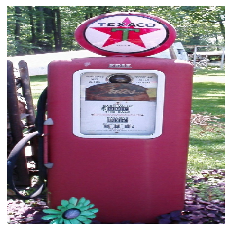

In [10]:
showTensorImage(openImage(fnames[0]))

### First example of `Batcher`

With our function `openImage` and our correspondence from labels to ints, we can create our template and the batcher. 

In [11]:
let template = ImageClassificationTemplate(
    openImage: openImage,
    labelFunc: { labelToInt[$0.parent.basename()]! }
)

And we can define our batcher! 

In [12]:
let batcher = Batcher(from: template, on: fnames, batchSize: 256, numWorkers: 8)

A batcher conforms to the `Sequence` protocol, so we can look at the first batch:

In [13]:
let b = batcher.first(where: {_ in true})!

In [14]:
b.0.shape

▿ [256, 224, 224, 3]
  ▿ dimensions : 4 elements
    - 0 : 256
    - 1 : 224
    - 2 : 224
    - 3 : 3


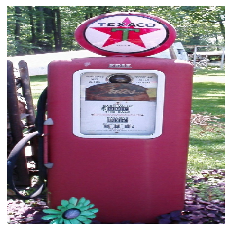

In [15]:
showTensorImage(b.0[0])

And time how long it takes to iterate though the whole training data:

In [16]:
import Dispatch

In [17]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.0.shape, b.1.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

7.904818317


As said before, another approach is to leave the images as tensor of floats after the resize. We can use that approach and time the difference:

In [18]:
func openImage1(_ filename: Path) -> Tensor<Float> {
    let loadedFile = _Raw.readFile(filename: StringTensor(filename.string))
    let loadedJpeg = _Raw.decodeJpeg(contents: loadedFile, channels: 3, dctMethod: "")
    let image =  _Raw.resizeBilinear(images: Tensor<UInt8>([loadedJpeg]), 
                                     size: Tensor<Int32>([224, 224]))
    return image[0]
}

Note: if we divide by 255 in the `openImage` function, we will need to not do it again in the template, so adjust the `divFactor` to 1 there. The template will do it on a full batch however, so it will be more efficient (see below for more details).

In [19]:
let template1 = ImageClassificationTemplate(
    openImage: openImage1,
    labelFunc: { labelToInt[$0.parent.basename()]! }
)

In [20]:
let batcher1 = Batcher(from: template1, on: fnames, batchSize: 256, numWorkers: 8)

In [21]:
let start = DispatchTime.now()
for b in batcher1 {
    var s = (b.0.shape, b.1.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

9.874690224


It's less efficient to do it that way.

### Opening images with SwiftCV

Let's now see how efficient we can be by using SwiftCV as a backend instead of `_Raw`.

In [22]:
import SwiftCV

In [23]:
func openCVImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

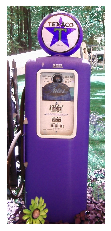

In [24]:
showTensorImage(Tensor<UInt8>(cvMat: openCVImage(fnames[0]))!)

With openCV images, the channels are in BGR instead of RGB so we need to siwtch them:

In [25]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

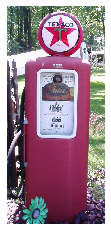

In [26]:
showTensorImage(Tensor<UInt8>(cvMat: BGRToRGB(openCVImage(fnames[0])))!)

We will need to resize our images to be able to batch them

In [27]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

And finally we'll need to convert them to a S4TF Tensor:

In [28]:
func cvImgToTensor(_ img: Mat) -> Tensor<UInt8> {
    return Tensor<UInt8>(cvMat: img)!
}

The whole transformation process is defined below, using the composition operator `>|` defined in SwiftData.

In [29]:
let processImage = openCVImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor

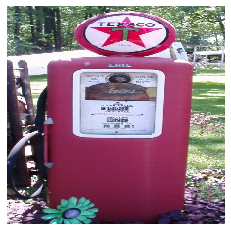

In [30]:
showTensorImage(processImage(fnames[0]))

As before we can define a new template and a batcher:

In [31]:
let templateCV = ImageClassificationTemplate(
    openImage: openCVImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor,
    labelFunc: { labelToInt[$0.parent.basename()]! }
)

In [32]:
let batcherCV = Batcher(from: template, on: fnames, batchSize: 256, numWorkers: 8)

In [33]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.0.shape, b.1.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

7.829520283


In the same ballbark as the `_Raw` backend.

## Behind the scenes

`ImageClassificationTemplate` is a convenience struct that provides an easy way to build a template suitable for a `Batcher`. It works well for a standard problem but you might need to tweak it a little bit in more complex situations. In general, the template passed to a `Batcher` must be an instance of a struct conforming to the `BatcherTemplate` protocol. This template provides hooks that let us customize the way the `Batcher` processes and collates the samples.

Here is the full protocol:
``` swift
public protocol BatcherTemplate {
    associatedtype Item
    associatedtype Sample
    associatedtype RawBatch
    associatedtype Batch
    
    func sampleIndices (_ dataset: [Item], shuffled: Bool) -> [Int]
    func processItem   (_ item:    Item)     -> Sample
    func processSamples(_ samples: [Sample]) -> [Sample]
    func collateSamples(_ samples: [Sample]) -> RawBatch 
    func processBatch  (_ batch:   RawBatch) -> Batch
}
```
In this protocol, the four associated types correspond to the following stage:
- `Item` is the base type of the raw elements in your dataset. By raw elements, we mean unprocessed and light-weight ones, such as the path to an image.
- `Sample` is the base type of the elements in your dataset (generally a tuple (input,target)). `Sample` can be the same as `Item` when your whole dataset fits in memory.
- `RawBatch` is the type of the unprocessed batch you obtain after collating your samples together in a batch, generally a tuple of tensors
- `Batch` is the final type of the batch (generally a tuple of tensors too), and the types of the elements of your `Batcher`.

Then, you can implement the following hooks:
- `sampleIndices` returns the array of indices that will be used to go through the dataset (a default implementation is provided). You would customize this if you need special behavior, only considering a few items or repeating some others in the same epoch, such as when using oversampling.
- `processItem` is the way you go form an `Item` to a `Sample` (a default implementation is provided when those types are equal).
- `processSamples` is a step that lets you change an array of samples just before they are collated into a batch (a default implementation is provided). This is useful when all your samples don't have the same shape yet and you might need to pad them (for instance in text problems).
- `collateSamples` is the function that collates your samples in a batch (TODO: make a default implementation when `Sample` conforms to `TensorGroup`)
- `processBatch` is the final step that goes from `RawBatch` to `Batch` (a default implementation is provided when those types are equal).

For instance, the `ImageClassificationTemplate` we used is implemented like this:
``` swift
public struct ImageClassificationTemplate<Scalar>: BatcherTemplate where Scalar: Numeric&TensorFlowScalar {
    public typealias Item = Path
    public typealias Sample = (Tensor<Scalar>, Int)
    public typealias RawBatch = (Tensor<Scalar>, Tensor<Int32>)
    public typealias Batch = (Tensor<Float>, Tensor<Int32>)
    
    let openImage: (Path) -> Tensor<Scalar>
    let labelFunc: (Path) -> Int
    let divFactor: Float
    
    public init(openImage: @escaping (Path) -> Tensor<Scalar>, 
         labelFunc: @escaping (Path) -> Int, 
         divFactor: Float = 255) {
        (self.openImage, self.labelFunc, self.divFactor) = (openImage, labelFunc, divFactor)
    }
    
    public func processItem(_ item: Item) -> Sample {
        return (openImage(item), labelFunc(item))
    }
    
    public func collateSamples(_ samples: [Sample]) -> RawBatch {
        return (Tensor(stacking: samples.map { $0.0 }), Tensor(samples.map { Int32($0.1) }))
    }
    
    public func processBatch(_ batch: RawBatch) -> Batch {
        return (Tensor<Float>(batch.0) / self.divFactor, batch.1)
    }
}
```